In [130]:
import importlib
import JeffUtils
importlib.reload(JeffUtils)

<module 'JeffUtils' from 'C:\\Users\\j3ff1\\Documents\\School Work\\MLProjects\\TelecomChurnAnalysis\\JeffUtils.py'>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm 
import matplotlib.pyplot as plt
import math
import scipy
import re

In [3]:
pd.set_option('display.max_columns', None)

we set a predetermined random seed so our experiment results can be easily replicated 

In [4]:
RANDOM_SEED = 1337

# Loading Raw Data

Load in data from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download

In [5]:
raw_data = pd.read_csv('telecomChurn.zip')

In [6]:
raw_data.head(5)

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005


## Handling column descriptions

Since there is literally a hundred columns in this dataset, lets take a general look at what kind of data is available. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import OPTICS, KMeans
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import spacy

### read-in column descriptions

column descriptions are scraped straight from the kaggle website via beautifulsoup

In [8]:
col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()

In [9]:
col_desc.head(5)

,col_desc
rev_Mean,Mean monthly revenue (charge amount)
mou_Mean,Mean number of monthly minutes of use
totmrc_Mean,Mean total monthly recurring charge
da_Mean,Mean number of directory assisted calls
ovrmou_Mean,Mean overage minutes of use


### Preprocess column descriptions

In [10]:
#Remove stop words
col_desc['clean_desc'] = (
    col_desc['col_desc']
    .apply(gensim.parsing.preprocessing.remove_stopwords)
)

#Remove characters that are not decimals,
#not letters, and not white space
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('[^a-zA-Z0-9_ ]','')
)
#Replace double whitespace with single space
#created from operation above
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('  ',' ')
)

In [11]:
nlp = spacy.load('en_core_web_sm')

In [12]:
#Tokenize words in the cleaned description and lemmatize them
col_desc['tokenized'] = col_desc['clean_desc'].apply(lambda x: [token.lemma_ for token in nlp(x)])
#Join lemmatized tokens back into single string for ease of use
col_desc['lemmatized'] = col_desc['tokenized'].apply(lambda x: ' '.join(x))

In [13]:
col_desc.head(5)

,col_desc,clean_desc,tokenized,lemmatized
rev_Mean,Mean monthly revenue (charge amount),Mean monthly revenue charge amount,"[mean, monthly, revenue, charge, amount]",mean monthly revenue charge amount
mou_Mean,Mean number of monthly minutes of use,Mean number monthly minutes use,"[mean, number, monthly, minute, use]",mean number monthly minute use
totmrc_Mean,Mean total monthly recurring charge,Mean total monthly recurring charge,"[mean, total, monthly, recur, charge]",mean total monthly recur charge
da_Mean,Mean number of directory assisted calls,Mean number directory assisted calls,"[mean, number, directory, assist, call]",mean number directory assist call
ovrmou_Mean,Mean overage minutes of use,Mean overage minutes use,"[mean, overage, minute, use]",mean overage minute use


### Tfidf

Transform our column descriptions into a tf-idf matrix so that we have numerical data to work with

In [14]:
tfidf = TfidfVectorizer()
tfidfMatrix = tfidf.fit_transform(col_desc['lemmatized'])

### kmeans grouping

We'll try to cluster similar columns together via K-Means since its quic and dirty.

In [15]:
#import utility functions
from JeffUtils import graph_cluster_wc, graph_elbow

We try values from 5-20 clusters for the number of clusters parameter of K-Means

In [16]:
kmeans = []
for i in range(5,21):
    km = KMeans(n_clusters=i,random_state=RANDOM_SEED)
    km.fit_predict(tfidfMatrix.toarray())
    kmeans.append((i,km.inertia_))

Then determine the elbow of the loss. The elbow is calculated via the second derivative of the loss curve at every point, and the point with the highest second derivative is chosen as our parameter for the number of clusters. From the graph below, we see that the optimal number of clusters would be 8 clusters.

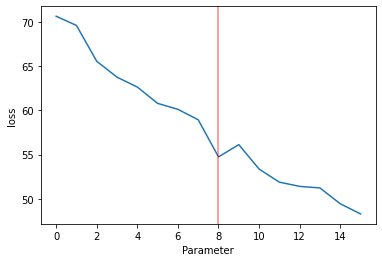

In [17]:
loss = pd.DataFrame(kmeans)[1].rename('loss')
#graph loss at every point and returns optimal point
elbow = graph_elbow(loss) 

we'll use 8 as our n_cluster parameter to run kmeans

In [18]:
kmeans = KMeans(n_clusters=elbow)
col_desc['kmeans_class'] = kmeans.fit_predict(tfidfMatrix.toarray())

We now use T-SNE with default parameters to reduce our high dimensional dataset to two dimensions, so that we may graph our clusters for a quick and dirty sanity check

In [58]:
from sklearn.manifold import TSNE

In [63]:
tsne = TSNE(n_components=2,
            perplexity = 30,
            learning_rate='auto',
            init='pca',
            random_state=RANDOM_SEED)

In [64]:
tsneX = tsne.fit_transform(tfidfMatrix.toarray())

C:\Users\j3ff1\.conda\envs\xgboost\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


It seems like clusters 0,3,5 have very similar descriptions as their datapoints are pretty intermingled, while the other clusters all have relatively more clearly defined clusters.

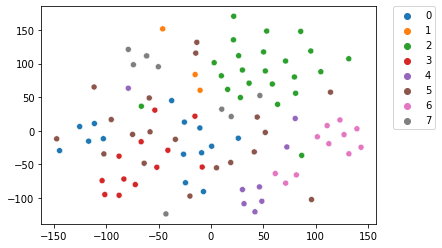

In [67]:
sns.scatterplot(x=tsneX[:,0],y=tsneX[:,1],hue=col_desc['kmeans_class'],
                palette=sns.color_palette("tab10")[:8])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [128]:
from JeffUtils import graph_all_cluster_wc

In [133]:
ls[2]

array(['Mean monthly revenue (charge amount)', 'Mean overage revenue',
       ' N', 'New cell phone user', ' Credit class code',
       ' Account spending limit', ' Social group letter only',
       'Geogrpahic area ', 'Dualband', 'Handset: refurbished or new',
       'Handset web capability', 'Truck indicator ', 'RV indicator',
       'Home owner/renter status', 'Length of residence',
       ' Dwelling Unit type', 'Marital Status ', 'InfoBase match',
       'Estimated income', 'Dwelling size ',
       'Foreign travel dummy variable', 'Ethnicity roll-up code',
       'Credit card indicator', 'N'], dtype=object)

We now graph the 5 most common words appearing in each cluster, with the y axis representing the percentage of column descriptions with the word occuring in the cluster. Some clusters have clearly defined themes, while others may not. 

0) cluster 0 deals with a mean statstic for every minute
1) cluster 1 represents daily statistics
2) cluster 2 doesn't seem to have a clear theme, since the percentage of descriptions sharing a common word is very low
3) cluster 3 doesn't seem to have a clearly defined 
4) cluster 4 deals with statistics across the customer life
5) cluster 4 
6) cluster 6 deals with monthly statistics
7) cluster 7 deals with statstics of the customer household

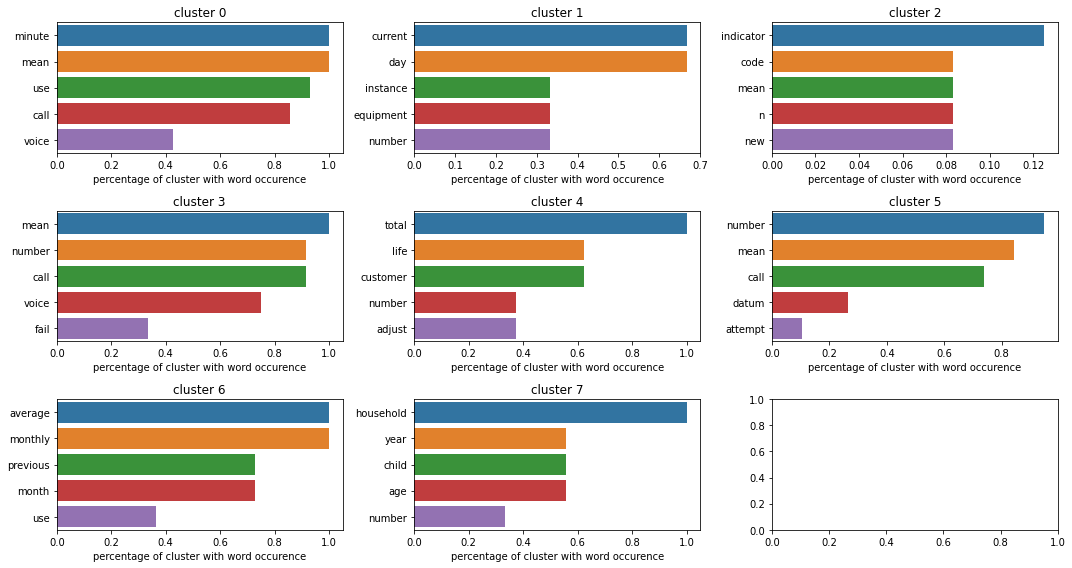

In [131]:
graph_all_cluster_wc(col_desc,'kmeans_class')